In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, G, m_e, hbar, m_p, c
from scipy.optimize import minimize_scalar
from scipy.integrate import solve_ivp

# Constants
M_sun = 1.989e30  # Solar mass in kg
R_sun = 6.957e8   # Solar radius in meters
gamma = 2.34  # polytropic index

# Function for electron degeneracy pressure
def degeneracy_pressure(mass, radius, za = 0.5, non_relativistic=True):
    """
    Calculate the electron degeneracy pressure.
    
    Parameters:
        mass (float): Mass in Kg
        radius (float): Radius in metre (m)
        non_relativistic (bool): If True, use non-relativistic formula.
        za (float): Ratio of number of protons/electrons to the number of nucleons (Z/A)

    Returns:
        float: Degeneracy pressure in Pascals.
    """
    # Electron number density (assuming fully ionized material)
    # Using mean molecular weight per electron = 2 for typical stellar material

    density = mass / ((4/3) * (pi) * (radius)**3)
    
    n_e = (za * (density /  m_p))  # for white dwarfs
    
    if non_relativistic:
        return (hbar**2 / (5 * m_e)) * (3 * pi**2)**(2/3) * n_e**(5/3)
    else:
        return (hbar * c / 4) * (3 * pi**2)**(1/3) * n_e**(4/3)

# Function for gravitational energy of a uniform-density sphere
def gravitational_energy(mass, radius):
    """
    Calculate the gravitational energy of a sphere.
    
    Parameters:
        mass (float): Mass in kg.
        radius (float): Radius in meters.
        
    Returns:
        float: Gravitational energy in Joules.
    """
    return -(3 / 5) * G * mass**2 / radius

# Function for total energy
def total_energy(mass, radius, non_relativistic=True):
    """
    Calculate the total energy (gravitational + degeneracy pressure).
    
    Parameters:
        mass (float): Mass in kg.
        radius (float): Radius in meters.
        non_relativistic (bool): If True, use non-relativistic degeneracy pressure.
        
    Returns:
        float: Total energy in Joules.
    """
    # Calculate degeneracy pressure
    P = degeneracy_pressure(mass, radius, non_relativistic)
    
    # Gravitational energy
    grav_energy = gravitational_energy(mass, radius)
    
    # Degeneracy energy (approximated as P * volume)
    degeneracy_energy = P * (4 / 3) * pi * radius**3
    
    return grav_energy + degeneracy_energy

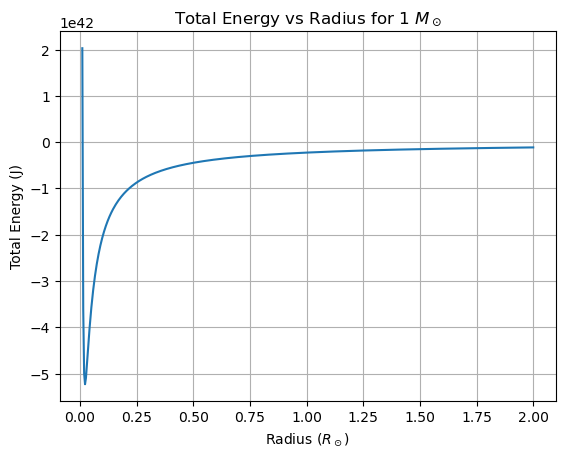

In [125]:
# plot E_total vs radius for a single mass (NON RELATIVISTIC CASE)
test_mass = 1.0 * M_sun
r_range = np.linspace(0.01 * R_sun, 2 * R_sun, 500)
energies = [total_energy(test_mass, i, non_relativistic = True ) for i in r_range]

plt.figure()
plt.plot(r_range / R_sun, energies)
plt.xlabel("Radius ($R_\\odot$)")
plt.ylabel("Total Energy (J)")
plt.title("Total Energy vs Radius for 1 $M_\\odot$")
plt.grid(True)
plt.show()

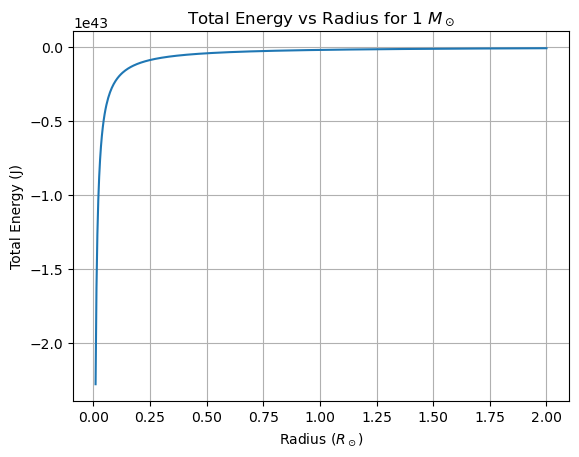

In [126]:
# plot E_total vs radius for a single mass (RELATIVISTIC CASE)
test_mass = 1.0 * M_sun
r_range = np.linspace(0.01 * R_sun, 2 * R_sun, 500)
energies = [total_energy(test_mass, r, non_relativistic = False ) for r in r_range]

plt.figure()
plt.plot(r_range / R_sun, energies)
plt.xlabel("Radius ($R_\\odot$)")
plt.ylabel("Total Energy (J)")
plt.title("Total Energy vs Radius for 1 $M_\\odot$")
plt.grid(True)
plt.show()


In [127]:
masses = np.linspace(0.2, 2.0, 19) * M_sun      # in kg

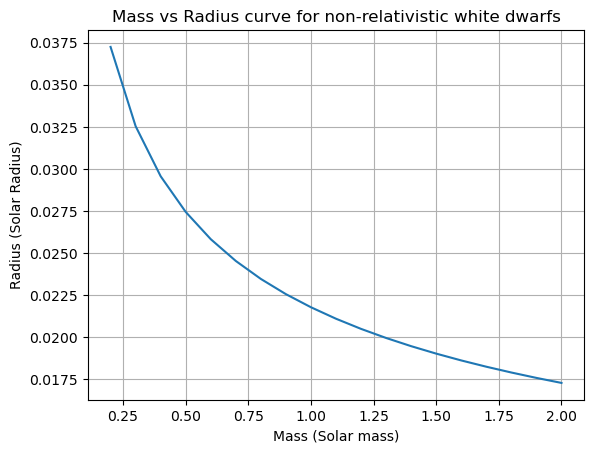

In [128]:
# MINIMISING TOTAL ENERGY TO GET RADIUS for non_relativistic
radii = []
def calc_R(mass, non_relativistic):
    obj = lambda radius: total_energy(mass, radius, non_relativistic)
    initial_guess = R_sun
    bounds = [1e-4 * R_sun, 10 * R_sun]
    result = minimize_scalar(obj, initial_guess, bounds = bounds, method = 'bounded')
    return result.x
for i in masses:
    radii.append(calc_R(i, True))
radii = np.array(radii)

plt.plot(masses / M_sun, radii / R_sun)
plt.title('Mass vs Radius curve for non-relativistic white dwarfs')
plt.xlabel('Mass (Solar mass)')
plt.ylabel('Radius (Solar Radius)')
plt.grid()
plt.show()

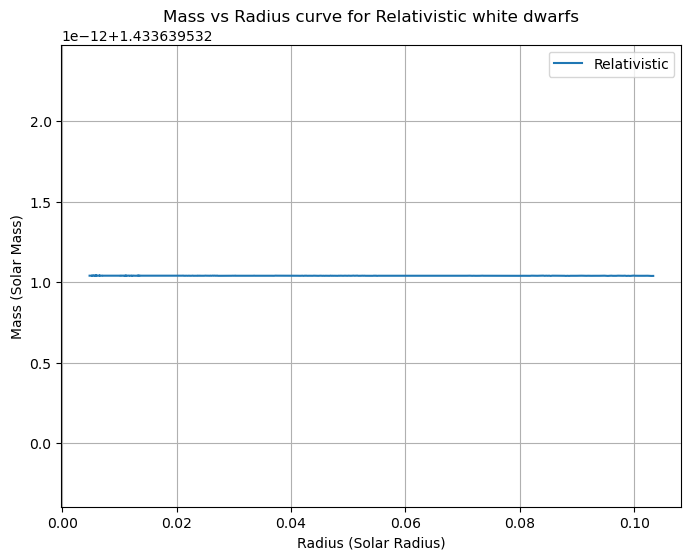

In [129]:
# CALCULATING EQUILIBRIUM RADIUS OF A RELATIVISTIC WHITE DWARF

# Calculating using the lane emden equation with a given central density

masses_ = []
radii_ = []

cen_den = np.logspace(8, 12, 1000)   # central density in Kg/m^3

n = 3       # polytropic index for relativistic white dwarfs

za = 0.5     # ration of number of electrons to number of nucleons (Z/A)


K = (hbar * c / 4) * (3 * pi**2)**(1/3) * (za / m_p)**(4/3)


e_range = [1e-5, 15]      
ei = e_range[0]
theta0 = 1 - (1/6) * ei**2                       # from lane-emden equation
phi0 = - (1/3) * ei

def lane_emden(e, y):
    theta, phi = y
    dtheta_de = phi
    dphi_de = -((2 * phi) / (e + 1e-12)) - (theta)**n       # 1e-12 to avoid any runtime divide by 0 errors
    return [dtheta_de, dphi_de]
    
def event(e, y):
    return y[0]
event.terminal = True

for d in cen_den:
    
    alpha = (((n+1) * K) / (4 * pi * G))**(0.5) * (d) ** (((1 - n) / (2 * n)))

    y0 = [theta0, phi0]
    sol = solve_ivp(lane_emden, e_range, y0, max_step = 50, dense_output  = True, events = event)

    e1 = sol.t_events[0][0] 
    rad = alpha * e1
    phi1 = sol.y_events[0][0][1]
    mass = 4 * pi * (alpha)**3 * (d) * (- (e1)**2 * phi1)
    masses_.append(mass)
    radii_.append(rad)


masses_ = np.array(masses_)
masses_ = masses_ / M_sun
radii_ = np.array(radii_)
radii_  = radii_/ R_sun

plt.figure(figsize=(8,6))
plt.plot(radii_, masses_, label="Relativistic")
plt.xlabel("Radius (Solar Radius)")
plt.ylabel("Mass (Solar Mass)")
plt.title('Mass vs Radius curve for Relativistic white dwarfs')
plt.grid()
plt.legend()
plt.show()

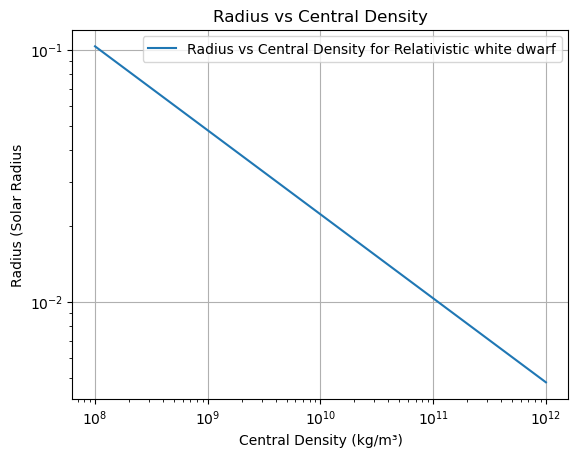

In [131]:
# Central density vs radius for a relativistic white dwarf

plt.figure()
plt.loglog(cen_den, radii_, label="Radius vs Central Density for Relativistic white dwarf")
plt.xlabel('Central Density (kg/m³)')
plt.ylabel('Radius (Solar Radius')
plt.title('Radius vs Central Density')
plt.grid()
plt.legend()
plt.show()
